<a href="https://colab.research.google.com/github/konstantinosPapado/US_Dollar_ML/blob/main/US_Dollar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exercise 3 - Ensemble Models

Import Necessary Libraries

In [2]:
import yfinance as yf
import plotly.express as px
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import pandas as pd

We will focus on US dollar index.

In [3]:
ticker_symbol = "DX-Y.NYB"
ticker = yf.Ticker(ticker_symbol)
df = ticker.history(period="5y").reset_index(drop=False)

In [4]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-11-06 00:00:00-05:00,92.570000,92.820000,92.180000,92.230003,0,0.0,0.0
1,2020-11-09 00:00:00-05:00,92.239998,92.959999,92.129997,92.730003,0,0.0,0.0
2,2020-11-10 00:00:00-05:00,92.760002,92.970001,92.599998,92.750000,0,0.0,0.0
3,2020-11-11 00:00:00-05:00,92.699997,93.209999,92.610001,93.040001,0,0.0,0.0
4,2020-11-12 00:00:00-05:00,93.010002,93.139999,92.779999,92.959999,0,0.0,0.0
...,...,...,...,...,...,...,...,...
1253,2025-10-31 00:00:00-04:00,99.489998,99.839996,99.419998,99.800003,0,0.0,0.0
1254,2025-11-03 00:00:00-05:00,99.750000,99.989998,99.709999,99.870003,0,0.0,0.0
1255,2025-11-04 00:00:00-05:00,99.980003,100.260002,99.739998,100.220001,0,0.0,0.0
1256,2025-11-05 00:00:00-05:00,100.180000,100.360001,100.059998,100.199997,0,0.0,0.0


Dropping the columns "Volume", "Dividends" and "Stock Splits"

In [5]:
df.drop(columns=["Volume", "Dividends", "Stock Splits"], inplace=True)

Plot a line for each of High, Low, Open and Close

In [6]:
fig = px.line(df, x = "Date",y = ["High","Low","Open","Close"],width = 1400, height=800)
fig.show()

This time-series appears to be non-stationary as the median, deviation appear to change with time.

If we were to train a Regressor in  non static time series, the problem would be that the model would not be able to capture the connection that the data have. Also, there is the fear in that the relationship of the data might change in the future, so our model will not be able to correctly predict future instances.




Could we predicti the value of "Close" for a given day, if we were given the data of the previous day?
In theory this can be achived, but the accuracy of the model might not be great. In order for the model to fully grasp the relationship between the next day "Close", would require the next day "Close" to be unaffected by the feature values of its day, which is not happening in the real world. Thereby, a model can be created but its accuracy will be lacking. So we cannot also find a function that would fulfill this criteria.

Would a random train-test split have any meaning in this scenario?
No, a split like this will most likely result in losing valuable information about the data, since the data are time-dependent based on their "Date", so a loss of time-alignment is expected. A better approach would be to train the model with values up to a certain date, and use the following instances as test set.

We will split the dataset for train with all the values unti 2024, and test with all the values for 2024-2025.

In [7]:
train_dataframe = df[df["Date"]<"2024-01-01"].copy()
test_dataframe = df[(df["Date"]>="2024-01-01") & (df["Date"]<"2025-01-01")].copy()
train_dataframe=train_dataframe.drop(columns="Date")
test_dataframe=test_dataframe.drop(columns="Date")

In [8]:
def create_timeframes(data_df, window_size):
  timeframes = []
  timeframe_targets = []
  data_array = data_df.to_numpy()
  close_index = data_df.columns.get_loc("Close")
  for i in range(data_df.shape[0] - window_size):
      end = i + window_size
      timeframes.append(data_array[i: end])
      timeframe_targets.append(data_array[end, close_index])

  return np.array(timeframes), np.array(timeframe_targets)


inputs, targets = create_timeframes(train_dataframe, 5)
inputs[0], inputs.shape, targets.shape

(array([[92.56999969, 92.81999969, 92.18000031, 92.23000336],
        [92.23999786, 92.95999908, 92.12999725, 92.73000336],
        [92.76000214, 92.97000122, 92.59999847, 92.75      ],
        [92.69999695, 93.20999908, 92.61000061, 93.04000092],
        [93.01000214, 93.13999939, 92.77999878, 92.95999908]]),
 (786, 5, 4),
 (786,))

The size of the dataframe is crucial when it comes to the model creation and should align in regards with the goal( how far in the future we want to make predictions), for example if we want next day predictions, a timeframe of 5 could be chosen, but if we want a month after predictions a high timeframe might be required such as 30+, and it also depends if data are seasonal or not. So, the further we want predictions in the future, the higher the timeframe will be, so the model can learn the correct relationship that the data have with the target.

Splitting the data for a timeframe of 5.

In [9]:
window = 5
train_inp, train_tar = create_timeframes(train_dataframe, window)
test_inp, test_tar = create_timeframes(test_dataframe, window)
print(train_inp.shape, test_inp.shape)

num_feat = train_inp.shape[2]
train_flat = train_inp.reshape(train_inp.shape[0], window * num_feat)
test_flat = test_inp.reshape(test_inp.shape[0], window * num_feat)
print(train_flat.shape, test_flat.shape)
print(train_flat[0])


(786, 5, 4) (247, 5, 4)
(786, 20) (247, 20)
[92.56999969 92.81999969 92.18000031 92.23000336 92.23999786 92.95999908
 92.12999725 92.73000336 92.76000214 92.97000122 92.59999847 92.75
 92.69999695 93.20999908 92.61000061 93.04000092 93.01000214 93.13999939
 92.77999878 92.95999908]


In [10]:
lr = LinearRegression()
lr.fit(train_flat, train_tar)
lr_pred_train = lr.predict(train_flat)
lr_pred_test = lr.predict(test_flat)
lr_train_mae = mean_absolute_error(train_tar, lr_pred_train)
lr_test_mae = mean_absolute_error(test_tar, lr_pred_test)
print("Linear Regression:")
print("Train MAE: ", lr_train_mae)
print("Test MAE: ", lr_test_mae)

Linear Regression:
Train MAE:  0.34575245774919117
Test MAE:  0.2845598676837101


In [11]:
rf = RandomForestRegressor(random_state=0)
rf.fit(train_flat, train_tar)
rf_pred_train = rf.predict(train_flat)
rf_pred_test = rf.predict(test_flat)
rf_train_mae = mean_absolute_error(train_tar, rf_pred_train)
rf_test_mae = mean_absolute_error(test_tar, rf_pred_test)
print("RandomForest:")
print("Train MAE: ", rf_train_mae)
print("Test MAE: ", rf_test_mae)

RandomForest:
Train MAE:  0.14738154277850063
Test MAE:  0.32500045436596564


In [12]:
bagging = BaggingRegressor(estimator= LinearRegression(),random_state=0)
bagging.fit(train_flat, train_tar)
bagging_pred_train = bagging.predict(train_flat)
bagging_pred_test = bagging.predict(test_flat)
bagging_train_mae = mean_absolute_error(train_tar, bagging_pred_train)
bagging_test_mae = mean_absolute_error(test_tar, bagging_pred_test)
print("BaggingRegressor:")
print("Train MAE: ", bagging_train_mae)
print("Test MAE: ", bagging_test_mae)

BaggingRegressor:
Train MAE:  0.34676879873320804
Test MAE:  0.2846559118273268


In [13]:
blr = BayesianRidge()
blr.fit(train_flat, train_tar)
blr_pred_train = blr.predict(train_flat)
blr_pred_test = blr.predict(test_flat)
blr_train_mae = mean_absolute_error(train_tar, blr_pred_train)
blr_test_mae = mean_absolute_error(test_tar, blr_pred_test)
print("BayesianRidge:")
print("Train MAE: ", blr_train_mae)
print("Test MAE: ", blr_test_mae)

BayesianRidge:
Train MAE:  0.34566703455412157
Test MAE:  0.28490353663629037


In [14]:
estim = [('linreg',LinearRegression()),('tree',DecisionTreeRegressor(random_state=0))]
stack = StackingRegressor(estimators=estim, final_estimator=LinearRegression())
stack.fit(train_flat, train_tar)
stack_pred_train = stack.predict(train_flat)
stack_pred_test = stack.predict(test_flat)
stack_train_mae = mean_absolute_error(train_tar, stack_pred_train)
stack_test_mae = mean_absolute_error(test_tar, stack_pred_test)
print("StackingRegressor:")
print("Train MAE: ", stack_train_mae)
print("Test MAE: ", stack_test_mae)

StackingRegressor:
Train MAE:  0.3551552107660649
Test MAE:  0.28729264057932724


Based on the above models, the best test MAE is from the Linear Regression model.

In [15]:
mae_train=[lr_train_mae,rf_train_mae,bagging_train_mae,blr_train_mae,stack_train_mae]
mae_test=[lr_test_mae,rf_test_mae,bagging_test_mae,blr_test_mae,stack_test_mae]

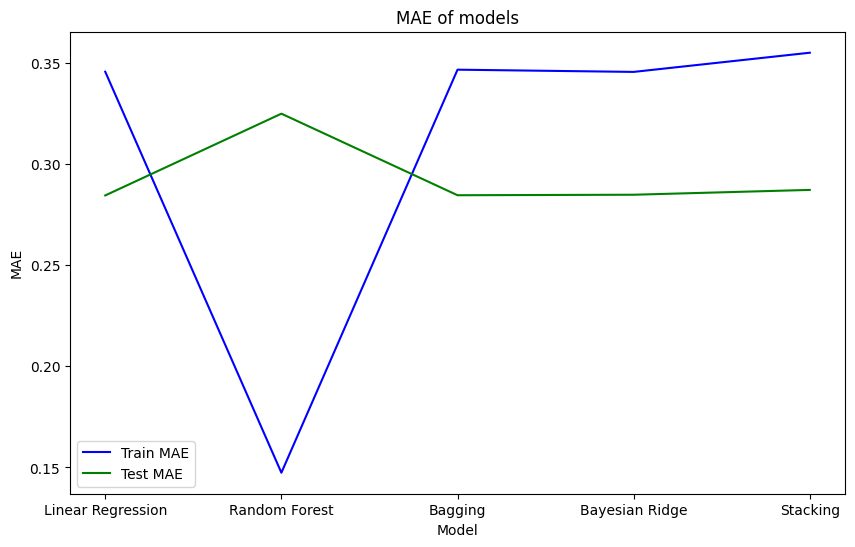

In [16]:
labels = ['Linear Regression', 'Random Forest', 'Bagging', 'Bayesian Ridge', 'Stacking']
plt.figure(figsize=(10, 6))
plt.plot(labels,mae_train, label='Train MAE',color='blue')
plt.plot(labels,mae_test, label='Test MAE',color='green')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('MAE of models')
plt.legend()
plt.show()

In [17]:
df['Date']= pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df

,Date,Open,High,Low,Close,Month,Day
0,2020-11-06 00:00:00-05:00,92.570000,92.820000,92.180000,92.230003,11,6
1,2020-11-09 00:00:00-05:00,92.239998,92.959999,92.129997,92.730003,11,9
2,2020-11-10 00:00:00-05:00,92.760002,92.970001,92.599998,92.750000,11,10
3,2020-11-11 00:00:00-05:00,92.699997,93.209999,92.610001,93.040001,11,11
4,2020-11-12 00:00:00-05:00,93.010002,93.139999,92.779999,92.959999,11,12
...,...,...,...,...,...,...,...
1253,2025-10-31 00:00:00-04:00,99.489998,99.839996,99.419998,99.800003,10,31
1254,2025-11-03 00:00:00-05:00,99.750000,99.989998,99.709999,99.870003,11,3
1255,2025-11-04 00:00:00-05:00,99.980003,100.260002,99.739998,100.220001,11,4
1256,2025-11-05 00:00:00-05:00,100.180000,100.360001,100.059998,100.199997,11,5


The column Month might play a role in the better performance of our models, since the model can learn the relationship that each month has on the values of US dollar.

In [18]:
df_log_returns = df.copy()
for col in ['Open', 'High', 'Low', 'Close']:
    df_log_returns[col] = np.log(1 + df_log_returns[col].pct_change())
df_log_returns

,Date,Open,High,Low,Close,Month,Day
0,2020-11-06 00:00:00-05:00,NaN,NaN,NaN,NaN,11,6
1,2020-11-09 00:00:00-05:00,-0.003571,0.001507,-0.000543,0.005407,11,9
2,2020-11-10 00:00:00-05:00,0.005622,0.000108,0.005089,0.000216,11,10
3,2020-11-11 00:00:00-05:00,-0.000647,0.002578,0.000108,0.003122,11,11
4,2020-11-12 00:00:00-05:00,0.003339,-0.000751,0.001834,-0.000860,11,12
...,...,...,...,...,...,...,...
1253,2025-10-31 00:00:00-04:00,0.003524,0.001203,0.005042,0.002709,10,31
1254,2025-11-03 00:00:00-05:00,0.002610,0.001501,0.002913,0.000701,11,3
1255,2025-11-04 00:00:00-05:00,0.002303,0.002697,0.000301,0.003498,11,4
1256,2025-11-05 00:00:00-05:00,0.001998,0.000997,0.003203,-0.000200,11,5


array([[<Axes: title={'center': 'Date'}>,
        <Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>],
       [<Axes: title={'center': 'Low'}>,
        <Axes: title={'center': 'Close'}>,
        <Axes: title={'center': 'Month'}>],
       [<Axes: title={'center': 'Day'}>, <Axes: >, <Axes: >]],
      dtype=object)

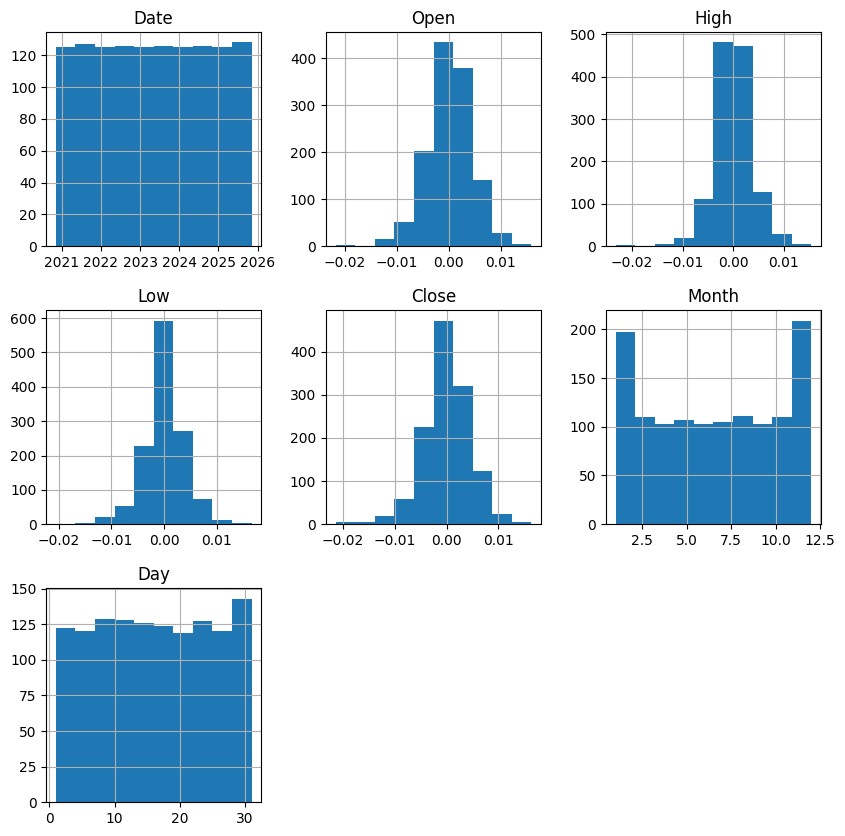

In [19]:
df_log_returns.hist(column = [f for f in df.columns], figsize=(10, 10))

By using logarithmic returns in our data, we achieve variance stabilization and we easier tackle seasonality and trends in the data.
Now if we set the target to Close, our models will predict the values of logarithmic return of Close, so we need to change them back in order to see the true value of Close.

Now, we will perform the same methodology as before, but with the new data, in order to see if we can achieve a better MAE.

In [20]:
df_log_returns = df_log_returns.iloc[1:]
train_dataframe = df_log_returns[df_log_returns["Date"]<"2024-01-01"].copy()
test_dataframe = df_log_returns[(df_log_returns["Date"]>="2024-01-01") & (df_log_returns["Date"]<"2025-01-01")].copy()
train_dataframe=train_dataframe.drop(columns="Date")
test_dataframe=test_dataframe.drop(columns="Date")

In [21]:
window = 5
train_inp, train_tar = create_timeframes(train_dataframe, window)
test_inp, test_tar = create_timeframes(test_dataframe, window)
print(train_inp.shape, test_inp.shape)

num_feat = train_inp.shape[2]
train_flat = train_inp.reshape(train_inp.shape[0], window * num_feat)
test_flat = test_inp.reshape(test_inp.shape[0], window * num_feat)
print(train_flat.shape, test_flat.shape)
print(train_flat[0])

(785, 5, 6) (247, 5, 6)
(785, 30) (247, 30)
[-3.57125898e-03  1.50715273e-03 -5.42597294e-04  5.40658737e-03
  1.10000000e+01  9.00000000e+00  5.62168262e-03  1.07590343e-04
  5.08853187e-03  2.15620474e-04  1.10000000e+01  1.00000000e+01
 -6.47095766e-04  2.57812865e-03  1.08008599e-04  3.12181656e-03
  1.10000000e+01  1.10000000e+01  3.33859757e-03 -7.51271250e-04
  1.83395239e-03 -8.60234796e-04  1.10000000e+01  1.20000000e+01
 -6.45355887e-04 -1.39669378e-03 -7.54754423e-04 -2.15374784e-03
  1.10000000e+01  1.30000000e+01]


In [22]:
lr = LinearRegression()
lr.fit(train_flat, train_tar)
lr_pred_train = lr.predict(train_flat)
lr_pred_test = lr.predict(test_flat)
lr_train_mae = mean_absolute_error(train_tar, lr_pred_train)
lr_test_mae = mean_absolute_error(test_tar, lr_pred_test)
print("Linear Regression:")
print("Train MAE: ", lr_train_mae)
print("Test MAE: ", lr_test_mae)

Linear Regression:
Train MAE:  0.003393273853117979
Test MAE:  0.0028649913262891705


In [23]:
rf = RandomForestRegressor(random_state=0)
rf.fit(train_flat, train_tar)
rf_pred_train = rf.predict(train_flat)
rf_pred_test = rf.predict(test_flat)
rf_train_mae = mean_absolute_error(train_tar, rf_pred_train)
rf_test_mae = mean_absolute_error(test_tar, rf_pred_test)
print("RandomForest:")
print("Train MAE: ", rf_train_mae)
print("Test MAE: ", rf_test_mae)

RandomForest:
Train MAE:  0.0013418016399733745
Test MAE:  0.0028589057624892546


In [24]:
bagging = BaggingRegressor(estimator= LinearRegression(),random_state=0)
bagging.fit(train_flat, train_tar)
bagging_pred_train = bagging.predict(train_flat)
bagging_pred_test = bagging.predict(test_flat)
bagging_train_mae = mean_absolute_error(train_tar, bagging_pred_train)
bagging_test_mae = mean_absolute_error(test_tar, bagging_pred_test)
print("BaggingRegressor:")
print("Train MAE: ", bagging_train_mae)
print("Test MAE: ", bagging_test_mae)

BaggingRegressor:
Train MAE:  0.003419773303643084
Test MAE:  0.00286653862136681


In [25]:
blr = BayesianRidge()
blr.fit(train_flat, train_tar)
blr_pred_train = blr.predict(train_flat)
blr_pred_test = blr.predict(test_flat)
blr_train_mae = mean_absolute_error(train_tar, blr_pred_train)
blr_test_mae = mean_absolute_error(test_tar, blr_pred_test)
print("BayesianRidge:")
print("Train MAE: ", blr_train_mae)
print("Test MAE: ", blr_test_mae)

BayesianRidge:
Train MAE:  0.003441523797435912
Test MAE:  0.0028096400454571987


In [26]:
estim = [('linreg',LinearRegression()),('tree',DecisionTreeRegressor(random_state=0))]
stack = StackingRegressor(estimators=estim, final_estimator=LinearRegression())
stack.fit(train_flat, train_tar)
stack_pred_train = stack.predict(train_flat)
stack_pred_test = stack.predict(test_flat)
stack_train_mae = mean_absolute_error(train_tar, stack_pred_train)
stack_test_mae = mean_absolute_error(test_tar, stack_pred_test)
print("StackingRegressor:")
print("Train MAE: ", stack_train_mae)
print("Test MAE: ", stack_test_mae)

StackingRegressor:
Train MAE:  0.0036544926027913985
Test MAE:  0.0027298472113985095


In [27]:
mae_train=[lr_train_mae,rf_train_mae,bagging_train_mae,blr_train_mae,stack_train_mae]
mae_test=[lr_test_mae,rf_test_mae,bagging_test_mae,blr_test_mae,stack_test_mae]

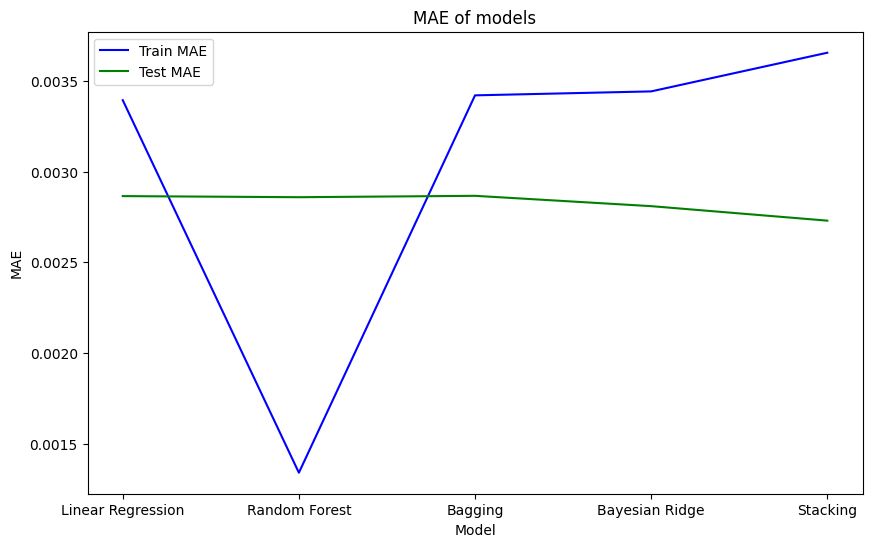

In [28]:
labels = ['Linear Regression', 'Random Forest', 'Bagging', 'Bayesian Ridge', 'Stacking']
plt.figure(figsize=(10, 6))
plt.plot(labels,mae_train, label='Train MAE',color='blue')
plt.plot(labels,mae_test, label='Test MAE',color='green')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('MAE of models')
plt.legend()
plt.show()

The best performing model now is Stacking Regressor.

In [30]:
y_test_abs = np.exp(test_tar)-1
y_pred_test = np.exp(stack_pred_test)-1

Now we will create the line plots for the actual target and the predicted values.

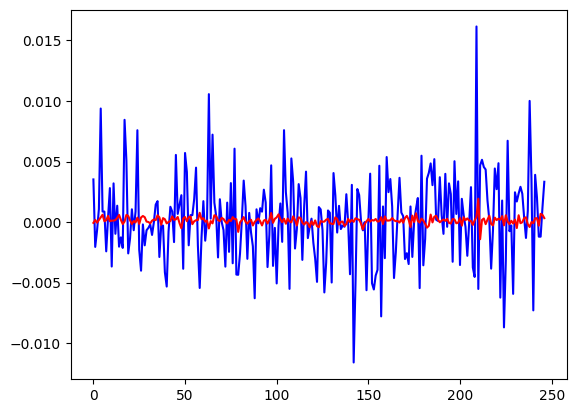

In [32]:
plt.plot(y_test_abs, label='Actual', color='blue')
plt.plot(y_pred_test, label='Predicted', color='red')
plt.show()